# Use Case: Analysis and Visualization

This notebook is designed to help users analyze and visualize data efficiently. It provides tools for exploring, and plotting datasets in an interractive manner. The dataset are already available inside the ``./data/era-5-land/download`` folder.

## 1. Specifying the paths and working directories

Specifying paths and working directories in Jupyter Notebook is essential for ensuring the notebook correctly accesses and saves files, enabling seamless data loading, script execution, and result storage. It eliminates confusion over file locations, reducing errors and making the code more portable and reproducible across different systems.

In [1]:
import os

# ---- Specify directories below ----
download_folder = r".\data\era5-land-monthly\download"  # Folder for downloaded data
output_folder = r".\data\era5-land-monthly\output"      # Folder for final outputs
# ---- End of user inputs ----

# Create directories if they do not exist
os.makedirs(download_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Read the dataset (File type: netCDF4)

In this section, we will access the recently downloaded dataset. Then visauzliate and analyse it. For the ease, the file is already requested, downloaded and made available in side the download folder

1. **Read Variable** data from the netCDF4 file 
2. **Create Basic Plot** to visualize the dataset
3. **Generate a Time Series Plot** for further analysis

### 2.1 Read Variable Data and Generate Basic Metadata

In this subsection, we will:
* Load variable data from the netCDF4 file
* Extract and display basic metadata such as dimension, variables, and attributes.

In [2]:
# Specify the dataset filename and construct its full path
filename = "reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc"
filepath = os.path.join(download_folder, filename)

# Display the constructed file path for verification
print(f"Dataset file path: {filepath}")

Dataset file path: .\data\era5-land-monthly\download\reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc


In [3]:
import netCDF4 as nc

# Open the NetCDF file in read mode
dataset = nc.Dataset(filepath, mode='r')

# List all variables in the dataset
variables_list = dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

# Extract coordinate data and the primary variable's data
lon_list = dataset['longitude'][:]  # Extract longitude
lat_list = dataset['latitude'][:]  # Extract latitude

Available variables: ['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m']


In [4]:
import pandas as pd

test_variable = 't2m'
variable_data = dataset[test_variable]

# Generate summary of the primary variable
summary = {
    "Variable Name": test_variable,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{test_variable}({', '.join(variable_data.dimensions)})",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display dataset summary as a DataFrame for better visualization
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
nc_summary

,Description,Remarks
0,Variable Name,t2m
1,Data Type,float32
2,Shape,"(898, 3, 4)"
3,Variable Info,"t2m(valid_time, latitude, longitude)"
4,Units,K
5,Long Name,2 metre temperature


In [5]:
import numpy as np
import pandas as pd

# Configure pandas display settings for better readability
pd.set_option('display.max_colwidth', None)

# Create a summary of the dataset
ds_summary = {
    "Institution": dataset.institution if hasattr(dataset, 'institution') else "N/A",
    "Dimensions": list(dataset.dimensions.keys()),
    "Variables": list(dataset.variables.keys()),
    "Variable dimensions": [
        np.shape(dataset[variable]) for variable in dataset.variables.keys()
    ],
}

# Convert the summary dictionary into a DataFrame for better visualization
dataset_summary = pd.DataFrame(list(ds_summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
dataset_summary

,Description,Remarks
0,Institution,European Centre for Medium-Range Weather Forecasts
1,Dimensions,"[valid_time, latitude, longitude]"
2,Variables,"[number, valid_time, latitude, longitude, expver, t2m]"
3,Variable dimensions,"[(), (898,), (3,), (4,), (898,), (898, 3, 4)]"


### 2.2 Create Basic Plot

The dataset contains **898 valid_time values**, representing monthly average data from **January 1950** to **October 2024**.

**Validation of `valid_time`:** (2024 - 1950)*12 + 10 = **898**

**Breakdown of Monthly Data:**

<div align="center" style="font-size: 13px;">

| Year  | Months |
|-------|--------|
| 1950  |   12   |
| 1951  |   12   |
| 1952  |   12   |
| ...   |   ...  |
| 2023  |   12   |
| 2024  |   10   |
| **Total** | **898** |

</div>

Now lets generate a plot for **August 1980** to visualize the spatial distribution of the dataset for that specific month.


In [6]:
# Define the target year and month for visualization
selected_year = 1980
selected_month = 8

# Calculate the band index for the selected year and month
# Index is determined by the position in the time dimension
band_index = (selected_year - 1950) * 12 + (selected_month - 1)

# Extract the data slice corresponding to the selected year and month
# This gives the spatial data (latitude x longitude) for the specified time
band_data = variable_data[band_index,:,:]

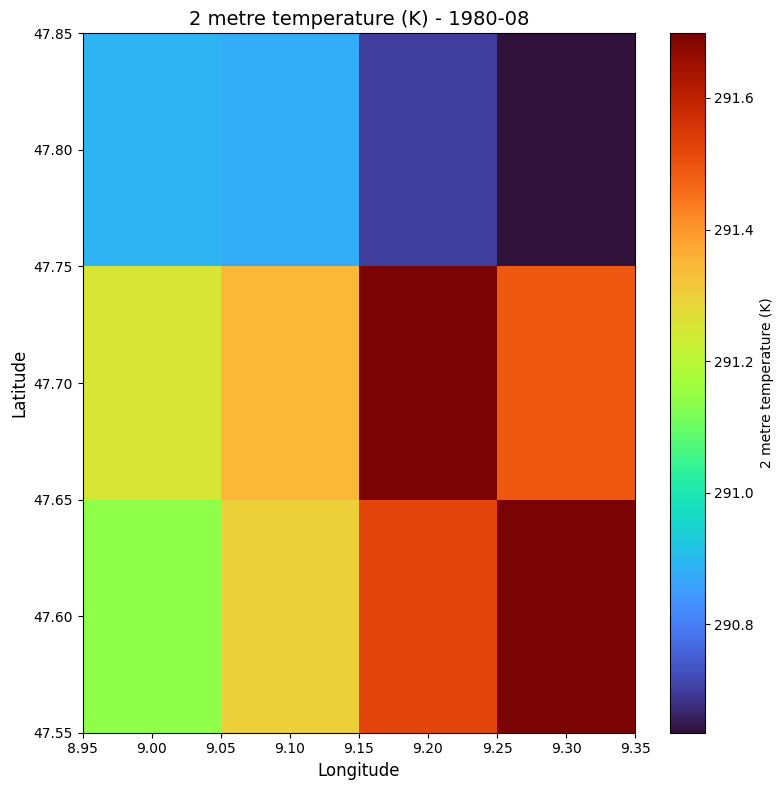

In [7]:
import matplotlib.pyplot as plt

# Plot the data using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Load predefined colormap
cmap = plt.get_cmap("turbo")

# Create a pseudo-color plot for the data
pcm = ax.pcolormesh(
    lon_list,
    lat_list,
    band_data,
    cmap=cmap,
    shading="auto",
)

# Add colorbar with units
cbar = plt.colorbar(pcm, ax=ax, label=f'{summary["Long Name"]} ({summary["Units"]})')

# Set plot title and labels
ax.set_title(
    f'{summary["Long Name"]} ({summary["Units"]}) - {selected_year}-{selected_month:02d}',
    fontsize=14,
)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

### Now, lets make the plot a bit more informative

In [8]:
import numpy as np
import math as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Convert the temperature data from K to °C
band_data_C = variable_data[band_index,:,:]-273.15

# Calculate minimum and maxium value within the band data
vmin = np.nanmin(band_data_C)
vmax = np.nanmax(band_data_C)

vmin_floor = ma.floor(vmin * 10) / 10
vmax_ceil = ma.ceil(vmax * 10) / 10

# Compute interval for color bar
interval = 0.1
bins = int((vmax_ceil - vmin_floor)/interval)

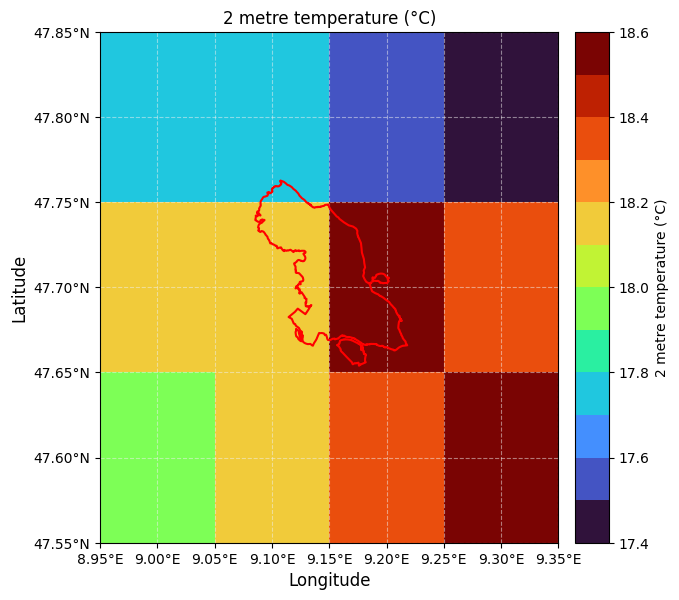

In [9]:
# Function to format latitude tick labels
def format_latitude(x, pos):
    return f"{x:.2f}°N"

# Function to format longitude tick labels
def format_longitude(x, pos):
    return f"{x:.2f}°E"

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Load predefined Colormap with 10 discrete colors
cmap = plt.get_cmap('turbo', bins)

pcm = ax.pcolormesh(lon_list, 
                     lat_list,
                     band_data_C,
                     cmap=cmap,
                     vmin=vmin_floor,
                     vmax=vmax_ceil)

# Add administrative boundary of Konstanz (Shapefile)
germany_shp = r".\shapefiles\kn_boundary.shp"
germany_boundary = gpd.read_file(germany_shp)
germany_boundary.boundary.plot(ax=ax, edgecolor='red')

# Plot color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)
plt.colorbar(pcm, cax=cax, label=f'{summary["Long Name"]} (°C)')

# Add grid lines
ax.grid(visible=True, which='major', color='#f0f0f0', linestyle='--', alpha=0.5)

# Set custom tick formatters for latitude and longitude
ax.xaxis.set_major_formatter(FuncFormatter(format_longitude))
ax.yaxis.set_major_formatter(FuncFormatter(format_latitude))

ax.set_title(f'{summary["Long Name"]} (°C)')
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xlabel('Longitude', fontsize=12)

plt.show()

### 2.3 Generate a Time Series Plot

Create time series plot for August from year 1950 to 2024

In [10]:
# Initialize lists to store statistics
mean_values_list = []
median_values_list = []
std_values_list = []

# Calculate the total number of time bands
total_bands = range(variable_data.shape[0])

# Derive year and month lists based on the time index
year_list = [(band_index // 12) + 1950 for band_index in total_bands]
month_list = [(band_index % 12) + 1 for band_index in total_bands]

# Iterate over all bands to compute statistics
for band_index in total_bands:
    # Convert Kelvin to Celsius
    band_data = variable_data[band_index, :, :] - 273.15

    # Compute and append statistics
    mean_values_list.append(np.nanmean(band_data))  # Mean excluding NaNs
    median_values_list.append(np.ma.median(band_data))  # Median for masked arrays
    std_values_list.append(np.nanstd(band_data))  # Standard deviation excluding NaNs

# Create a dictionary to store results
df_data = {
    'Year': year_list,
    'Month': month_list,
    'Mean': mean_values_list,
    'Median': median_values_list,
    "Std Dev": std_values_list
}

# Convert dictionary to DataFrame
df_statistics = pd.DataFrame(df_data)

# Display the first few rows of the DataFrame
df_statistics.head()

,Year,Month,Mean,Median,Std Dev
0,1950,1,-1.677582,-1.677582,0.263794
1,1950,2,2.095927,2.076721,0.314301
2,1950,3,4.579813,4.523987,0.255085
3,1950,4,7.100454,7.199249,0.331744
4,1950,5,14.580119,14.644409,0.342235


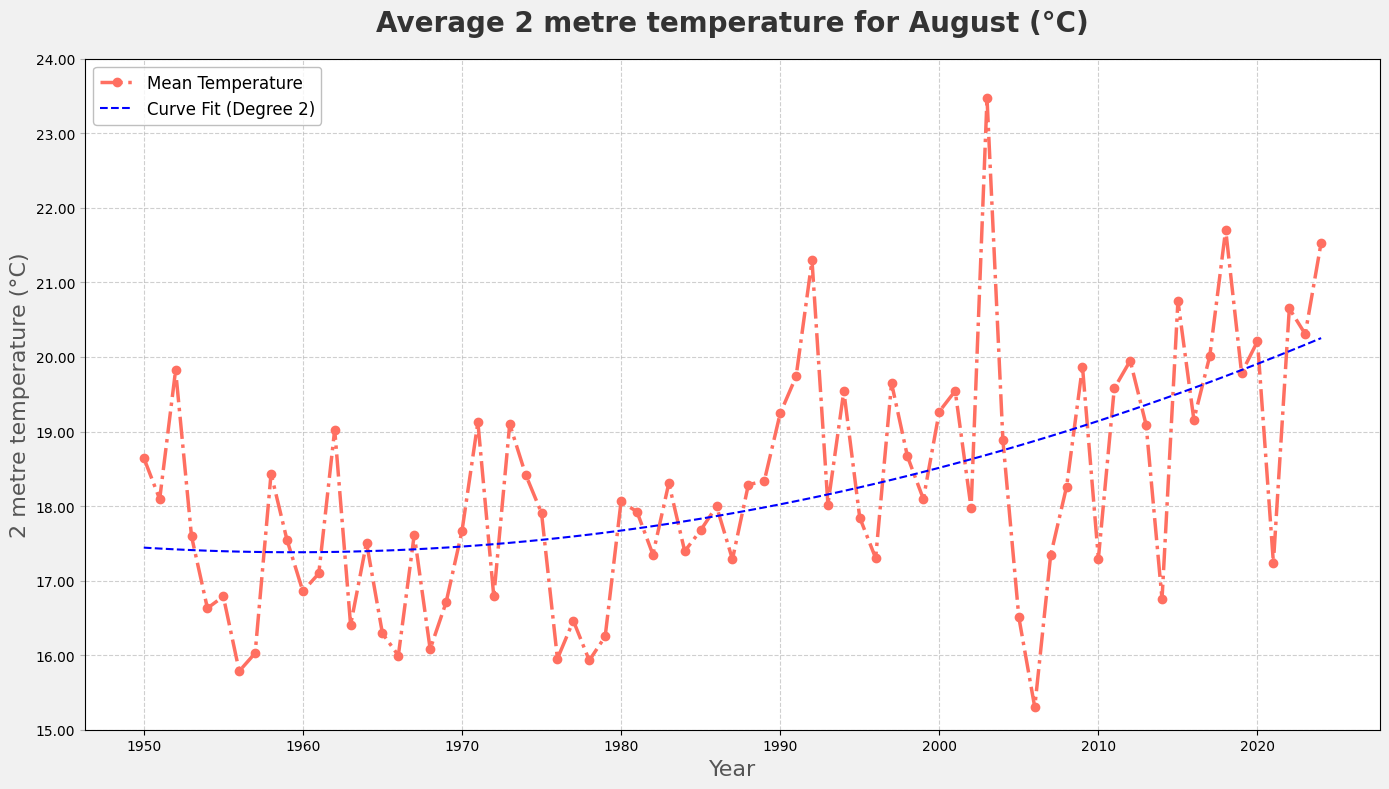

In [11]:
import matplotlib.ticker as ticker


# Filter the statistics DataFrame by the selected month (August)
selected_month = 8  # August
df_statistics_filtered = df_statistics[df_statistics['Month'] == selected_month]

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 8), facecolor='#f1f1f1')

# Titles and labels
ax.set_title(
    f'Average {summary["Long Name"]} for August (°C)',
    fontsize=20,
    fontweight='bold',
    color='#333333',
    pad=20
)
ax.set_xlabel("Year", fontsize=16, color='#555555')
ax.set_ylabel(f'{summary["Long Name"]} (°C)', fontsize=16, color='#555555')

# Update plot parameters for consistency
params = {
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

# Add grid and tick formatting
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.tick_params(axis='y', which='both', color='#b0b0b0')

# Define yaxis limits
ax.set_ylim(15,24)

# Plot the mean temperature trend
line1, = ax.plot(
    df_statistics_filtered['Year'],
    df_statistics_filtered['Mean'].astype(float),
    label='Mean Temperature',
    color='#ff6f61',
    linestyle='-.',
    marker='o',
    linewidth=2.5
)

# Fit a quadratic curve (degree 2) for the trend line
degree = 2  # Quadratic fit
coefficients = np.polyfit(
    df_statistics_filtered['Year'],
    df_statistics_filtered['Mean'].astype(float),
    degree
)
curve_fit = np.poly1d(coefficients)

# Plot the curve fit trend line
ax.plot(
    df_statistics_filtered['Year'],
    curve_fit(df_statistics_filtered['Year']),
    label=f'Curve Fit (Degree {degree})',
    color='blue',
    linestyle='--',
    linewidth=1.5
)

# Add legend
ax.legend(loc='upper left', fontsize=12, frameon=True, facecolor='#ffffff', edgecolor='#b0b0b0')

# Display the plot
plt.tight_layout()
plt.show()